In [15]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from lazypredict.Supervised import LazyClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [2]:
melanoma_vs_keratosis_features_targets = pd.read_csv('../mel_vs_keratosis_features_targets.csv')

In [3]:
melanoma_vs_keratosis_features_targets.head()

,image_id,blue_iqr,original_firstorder_Entropy,original_firstorder_Skewness,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_ngtdm_Complexity,original_ngtdm_Strength,melanoma,seborrheic_keratosis
0,ISIC_0000002,67,0.11,-0.31,1.28,1.93,0.01,0.94,1,0
1,ISIC_0000004,55,2.59,0.59,0.81,4.28,3.15,2.21,1,0
2,ISIC_0000013,28,0.90,-0.17,0.69,2.58,0.51,0.11,1,0
3,ISIC_0000022,103,0.31,-0.80,0.58,2.15,0.09,0.45,1,0
4,ISIC_0000026,64,0.16,-0.06,1.32,1.98,0.01,0.07,1,0


In [4]:
# Train and test several models

# separate features and target
X = melanoma_vs_keratosis_features_targets.iloc[:,1:-2]
y = melanoma_vs_keratosis_features_targets['melanoma']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [5]:
# Preliminary model training and evaluation with LazyClassifier
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:03<00:00,  9.20it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
SVC                                0.75               0.74     0.74      0.75   
LinearSVC                          0.74               0.74     0.74      0.74   
RandomForestClassifier             0.75               0.73     0.73      0.75   
NuSVC                              0.75               0.73     0.73      0.75   
RidgeClassifierCV                  0.74               0.73     0.73      0.74   
RidgeClassifier                    0.74               0.73     0.73      0.74   
LinearDiscriminantAnalysis         0.73               0.73     0.73      0.73   
AdaBoostClassifier                 0.73               0.72     0.72      0.73   
LogisticRegression                 0.73               0.72     0.72      0.73   
CalibratedClassifierCV             0.73               0.72     0.72      0.73   
LabelSpreading              

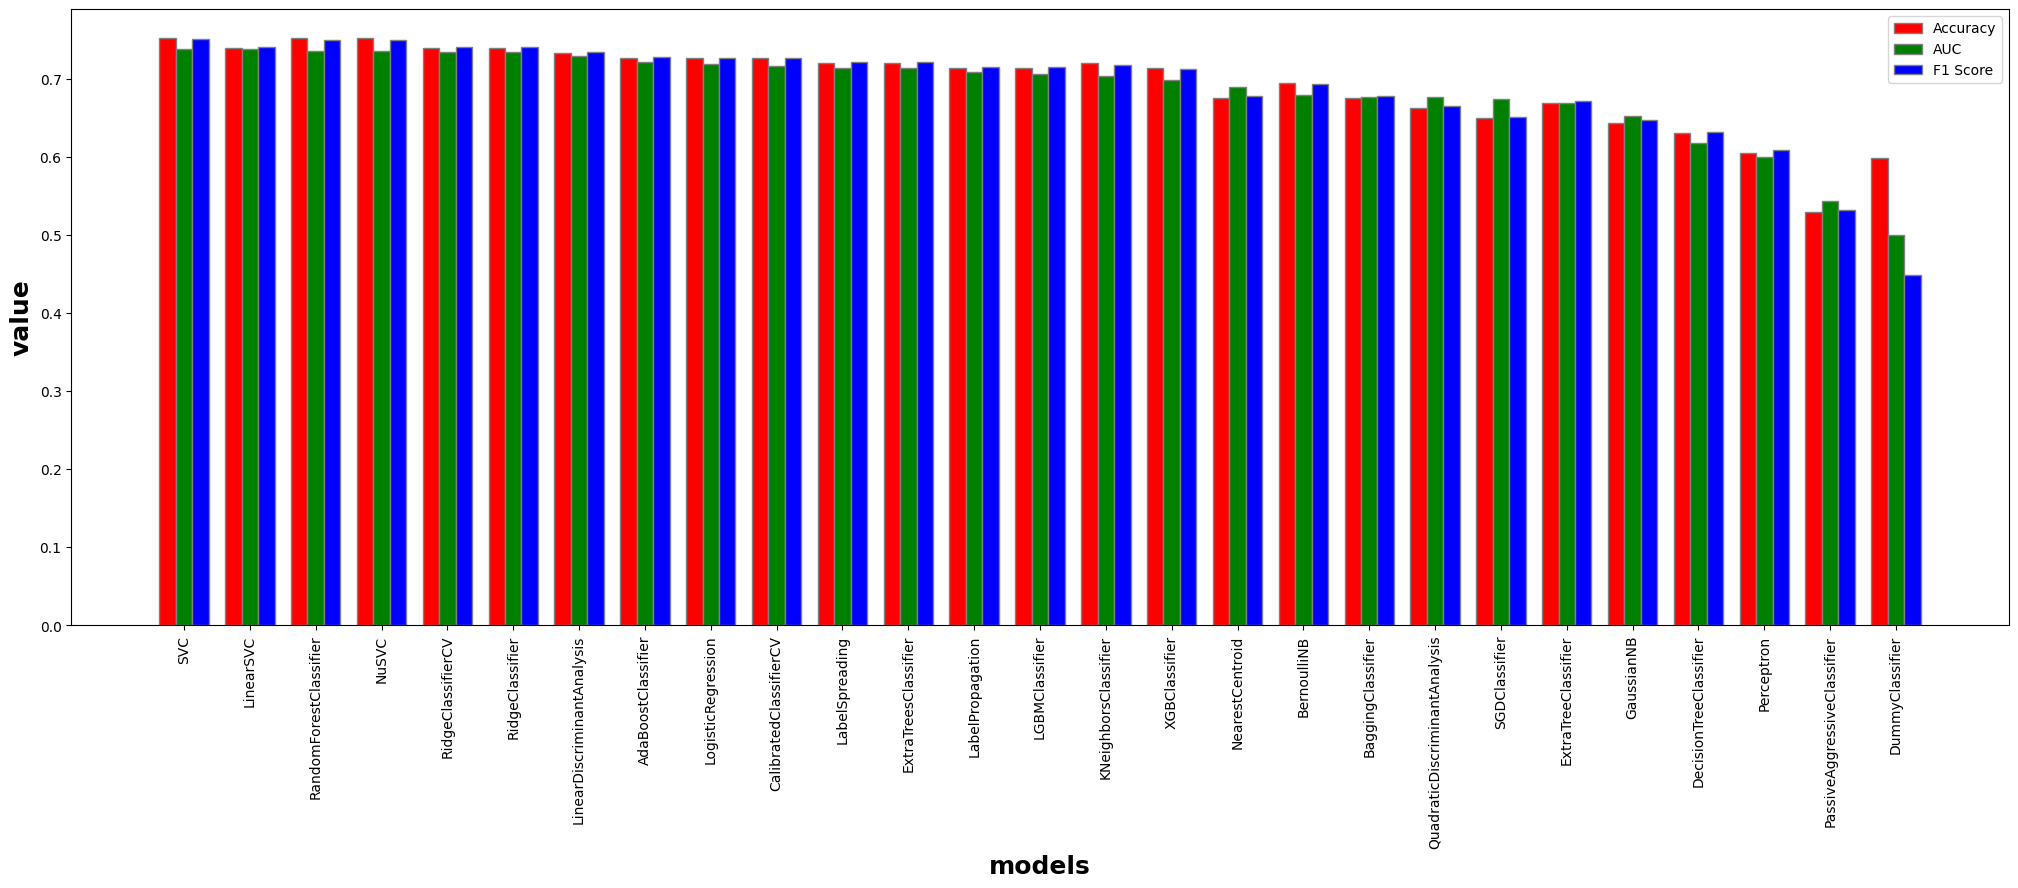

In [6]:
# Set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(25, 8))


# Set height of bar
acc = list(models['Accuracy'])
auc = list(models['ROC AUC'])
f1s = list(models['F1 Score'])


# Set position of bar on X axis
br1 = np.arange(len(acc))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]


# Make the plot
plt.bar(br1, acc, color ='r', width = barWidth, edgecolor = 'grey', label ='Accuracy')
plt.bar(br2, auc, color ='g', width = barWidth, edgecolor = 'grey', label ='AUC')
plt.bar(br3, f1s, color ='b', width = barWidth, edgecolor = 'grey', label ='F1 Score')


# Adding Xticks
plt.xlabel('models', fontweight ='bold', fontsize = 18)
plt.ylabel('value', fontweight ='bold', fontsize = 18)
plt.xticks([r + barWidth for r in range(len(acc))], list(models.index))

locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

plt.legend()
plt.savefig('../plots/mk_model_acc_f1s.png', bbox_inches='tight')
plt.show()

In [7]:
### HYPERPARAMETER FINETUNING ###

In [8]:
# Optimizing the RandomForest Classifier
rf_clf = RandomForestClassifier(random_state=1)

In [9]:
n_estimators = [75, 100, 200]
max_depth = [7, 10, 15]
min_samples_split = [5, 7, 10, 15]
min_samples_leaf = [5, 10, 20]
bootstrap = [True, False]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf,
              bootstrap = bootstrap)


gridF = GridSearchCV(rf_clf, hyperF, cv = 5, verbose = 0, 
                      n_jobs = -1, refit='accuracy', return_train_score=True)

bestF = gridF.fit(X_train, y_train)

In [10]:
print('Best score reached: {} with params: {} '.format(bestF.best_score_, bestF.best_params_))

Best score reached: 0.7557446808510638 with params: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 200} 


<AxesSubplot:>

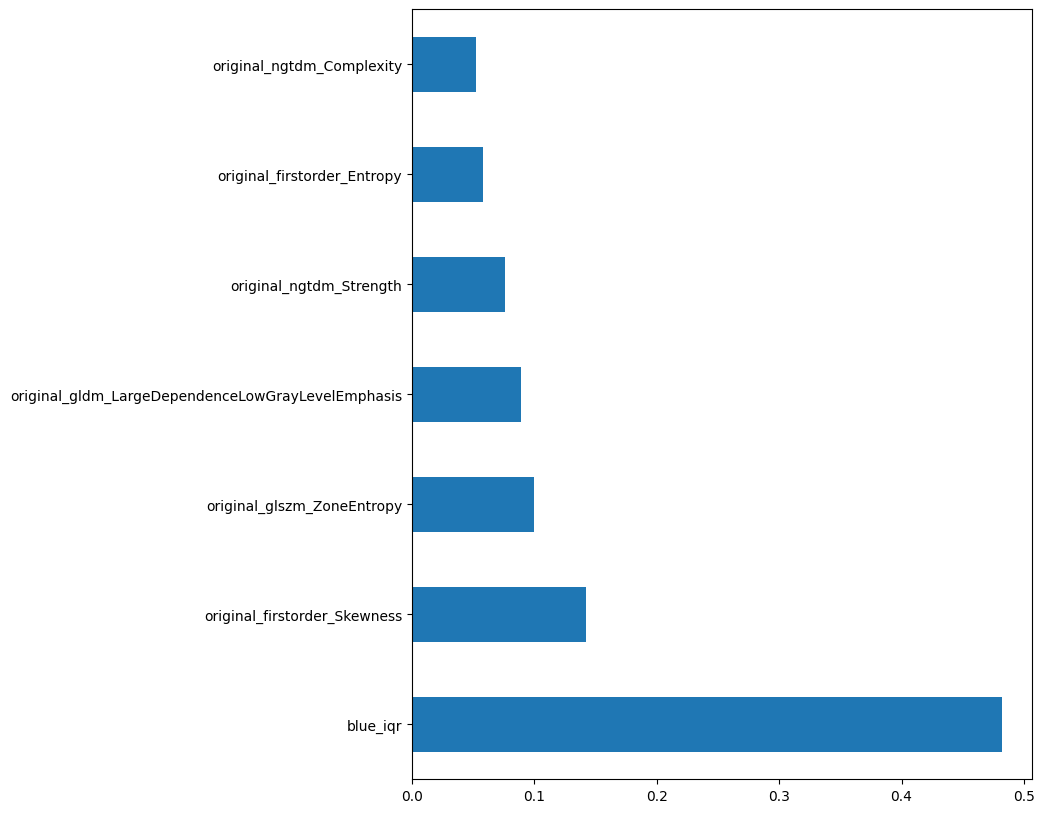

In [11]:
feat_imp = pd.Series(bestF.best_estimator_.feature_importances_, index=X.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(8,10))

In [12]:
y_predF = bestF.predict(X_test)

In [16]:
print('Model accuracy : {0:0.4f}'. format(accuracy_score(y_test, y_predF)))
print('Model recall : {0:0.4f}'. format(recall_score(y_test, y_predF, average='weighted') ))
print('Model roc/auc : {0:0.4f}'. format(roc_auc_score(y_test, y_predF), 
                                                       average="macro"))

Model accuracy : 0.7261
Model recall : 0.7261
Model roc/auc : 0.7032


In [ ]:
# optimizing SVM (SVC)

In [17]:
svc=SVC(C=100.0)

In [18]:
# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.7516


In [19]:
print('Model accuracy : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
print('Model recall : {0:0.4f}'. format(recall_score(y_test, y_pred, average='weighted') ))
print('Model roc/auc : {0:0.4f}'. format(roc_auc_score(y_test, y_pred), 
                                                       average="macro"))

Model accuracy : 0.7516
Model recall : 0.7516
Model roc/auc : 0.7324


In [ ]:
# Logistic Regression

In [ ]:
model = LogisticRegression()

# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

# define search
search = GridSearchCV(model, space, scoring='accuracy', n_jobs=-1, cv=cv)

# execute search
result = search.fit(X, y)

In [ ]:
print('Best score reached: {} with params: {} '.format(result.best_score_, result.best_params_))

In [ ]:
y_predF = result.predict(X_test)

In [ ]:
print('Model accuracy : {0:0.4f}'. format(accuracy_score(y_test, y_predF)))

In [ ]:
### define list of models to train and evaluate
model_list = [SVC, LinearSVC, RandomForestClassifier, NuSVC, RidgeClassifierCV]

In [ ]:
### define parameters for each model 
## svc
svc_params = [
                   {"gamma": "scale"}, {"gamma":"auto"},
                   {"kernel":'linear'}, {"kernel": 'poly'}, {"kernel": "rbf"}, {"kernel": "sigmoid"}, 
                   {"C":0.01}, {"C":0.1}, {"C":1}, {"C":5}, {"C":10}
             ]

## linearSVC
lin_svc_params = [
                  {"C":0.01}, {"C":0.1}, {"C":1}, {"C":5}, {"C":10}
                 ]

## RandomForestClassifier

rand_for_params = [
    
                  {"criterion": "gini"}, {"criterion": "entropy"}, {"criterion": "log_loss"},
                  {"max_features":"sqrt"},{"max_features": "log2"},{"max_features": None},
                  {"bootstrap":True}, {"bootstrap":False},
                  {"max_depth": 2}, {"max_depth": 3}
    
                  ]

## NuSVC

nu_svc_params = [
    
                {"nu":0.2},{"nu":0.5},{"nu":0.7},{"nu":0.8},
                {"kernel":'linear'}, {"kernel": 'poly'}, {"kernel": "rbf"}, {"kernel": "sigmoid"},
                {"gamma": "scale"}, {"gamma":"auto"}
                ]

## RidgeClassifierCV

ridge_class_params = [{}]


for model in model_list:
    print(model)

In [ ]:
### create list with models and params
modelclasses = [
    ["svc", SVC, svc_params],
    ["linearSVC", LinearSVC, lin_svc_params],
    ["nuSVC", NuSVC, nu_svc_params],
    ["random forest", RandomForestClassifier, rand_for_params],
    ["ridge classifier", RidgeClassifierCV, ridge_class_params]
]

In [ ]:
### iterate through each model and parameters, evaluate and get scores
insights = []
for modelname, Model, params_list in modelclasses:
    for params in params_list:
        model = Model(**params)
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        
        insights.append((modelname, model, params, score))

In [ ]:
model_data = pd.DataFrame(columns=['model','params','accuracy'])
for modelname, model, params, score in insights: 
    model_data = model_data.append(pd.Series([modelname, params, score], index=model_data.columns), ignore_index=True)